# Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

# Unziping images
Make sure the file is on the exact location!

In [ ]:
!unzip /content/images400duckduckgo.zip

In [ ]:
labels = ['beef', 'pork']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data('train')
val = get_data('test')

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[2][0])
plt.title(labels[train[0][1]])

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[-3][0])
plt.title(labels[train[-3][1]])

# Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=50,
)
batch_size = 8
train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 342 images belonging to 2 classes.


In [ ]:
class_dictionary = train_generator.class_indices
#---create a dictionary of labels---
class_dictionary = { value:key for key,value in
    class_dictionary.items()}
#---convert the dictionary to a list---
class_list = [value for _,value in class_dictionary.items()]
print(class_list)

['beef', 'pork']


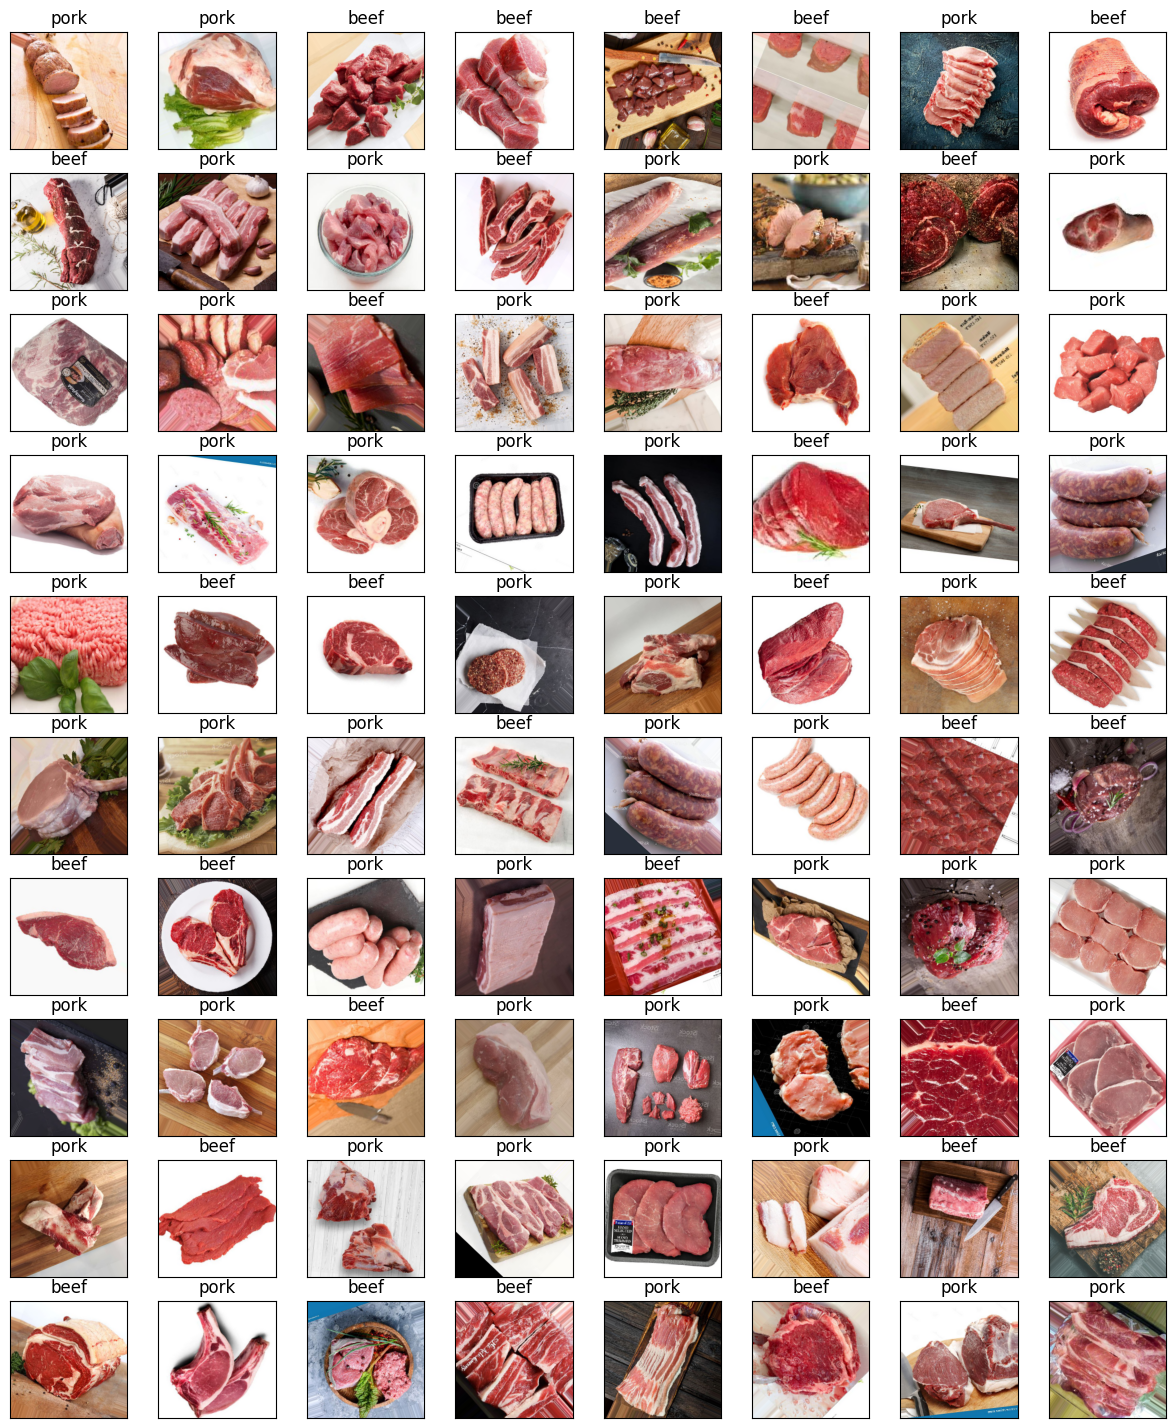

In [ ]:
rows = 10
fig, axes = plt.subplots(rows,batch_size)
for r in range(rows):
    #---get the batch of augmented images---
    image_batch = train_generator.next()
    #---get the number of images returned---
    images_count = image_batch[0].shape[0]

    for c in range(images_count):
        #---convert to unsigned integers for viewing---
        image = image_batch[0][c].astype('uint8')

        #---display the image---
        axes[r,c].imshow(image)
        #---display the label of the image---
        axes[r,c].title.set_text(
            class_list[np.argmax(image_batch[1][c])])
        #---hides the x and y-ticks---
        axes[r,c].set_xticks([])
        axes[r,c].set_yticks([])
fig.set_size_inches(15,18)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=batch_size,        # batch_size = 8
    class_mode='categorical',
    shuffle=True)

Found 342 images belonging to 2 classes.


# Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
#---number of fruits---
NO_CLASSES = max(train_generator.class_indices.values()) + 1
#---load the VGG16 model as the base model for training---
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
#---add our own layers---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)       # add dense layers so
                                           # that the model can
                                           # learn more complex
                                           # functions and
                                           # classify for better
                                           # results.
x = Dense(1024,activation='relu')(x)       # dense layer 2
x = Dense(512,activation='relu')(x)        # dense layer 3
preds = Dense(NO_CLASSES,
              activation='softmax')(x)     # final layer with
                                           # softmax activation
#---create a new model with the base model's original
# input and the new model's output---
model = Model(inputs = base_model.input, outputs = preds)
#---don't train the first 19 layers - 0..18---
for layer in model.layers[:19]:
    layer.trainable=False
#---train the rest of the layers - 19 onwards---
for layer in model.layers[19:]:
    layer.trainable=True

#---compile the model---
model.compile(optimizer='Adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#---train the model---
step_size_train = train_generator.n // train_generator.batch_size
history = model.fit(train_generator,
          steps_per_epoch=step_size_train,
          epochs=15)

Epoch 1/15
42/42 [==============================] - 188s 4s/step - loss: 0.3024 - accuracy: 0.8533
Epoch 2/15
42/42 [==============================] - 184s 4s/step - loss: 0.3257 - accuracy: 0.8862
Epoch 3/15
42/42 [==============================] - 184s 4s/step - loss: 0.2201 - accuracy: 0.9072
Epoch 4/15
42/42 [==============================] - 183s 4s/step - loss: 0.2314 - accuracy: 0.9012
Epoch 5/15
42/42 [==============================] - 184s 4s/step - loss: 0.2233 - accuracy: 0.8952
Epoch 6/15
42/42 [==============================] - 185s 4s/step - loss: 0.2641 - accuracy: 0.8802
Epoch 7/15
42/42 [==============================] - 183s 4s/step - loss: 0.2072 - accuracy: 0.9102
Epoch 8/15
42/42 [==============================] - 184s 4s/step - loss: 0.2330 - accuracy: 0.9072
Epoch 9/15
42/42 [==============================] - 183s 4s/step - loss: 0.2963 - accuracy: 0.9072
Epoch 10/15
42/42 [==============================] - 183s 4s/step - loss: 0.2574 - accuracy: 0.8772
Epoch 11/

In [ ]:
model.save('my_trained_model.h5')

## Tes Prediksi Gambar

In [ ]:
import cv2

def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224)) # asumsikan model menerima gambar berukuran 224x224
    return img

In [ ]:
import matplotlib.pyplot as plt

def predict_image(model, image_path):
    img = load_image(image_path)
    img = np.expand_dims(img, axis=0) # model menerima input dalam bentuk batch
    predictions = model.predict(img)
    label = np.argmax(predictions)

    if label == 0:
        plt.title("Predicted label: daging sapi")
    elif label == 1:
        plt.title("Predicted label: daging babi")
    else:
        plt.title("Predicted label: other")

    plt.imshow(img[0])
    plt.show()

In [ ]:
model = load_model("my_trained_model.h5")

In [ ]:
image_path = files.upload()
for y in image_path.keys():
  path = y

Saving 008_d1ddb761.jpg to 008_d1ddb761.jpg


1/1 [==============================] - 0s 487ms/step
Predicted label: daging sapi


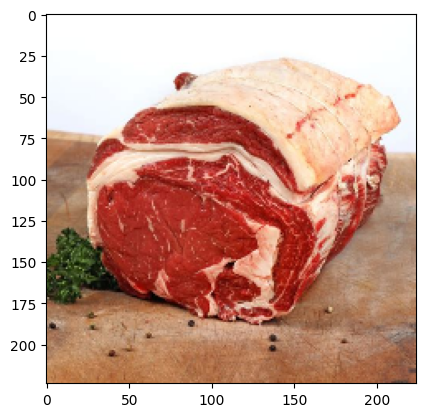

In [ ]:
label = predict_image(model, path)

## Tes Banyak Gambar Sekaligus

In [ ]:
import os

# path ke folder yang berisi gambar-gambar
folder_path = "/content/test/pork"

# mendapatkan list path dari setiap file gambar dalam folder tersebut
image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

# loop untuk memprediksi label pada setiap gambar
for image_path in image_paths:
    label = predict_image(model, image_path)
    print("Predicted label for", image_path, ":", label)